# Cart2Text

In [0]:
import numpy as np
from scipy.spatial import ConvexHull

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
#     rotations = np.vstack([
#         np.cos(angles),
#         -np.sin(angles),
#         np.sin(angles),
#         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

In [0]:
import numpy as np
from sklearn.metrics import mutual_info_score


def ConvPixel(FVec, xp, yp, A, B, base=1, custom_cut=None, index=0):
    n = len(FVec)
    M = np.ones([int(A), int(B)]) * base
    for j in range(0, n):
        # M[int(xp[j]) - 1, int(yp[j]) - 1] = 0
        M[int(xp[j]) - 1, int(yp[j]) - 1] = FVec[j]
    zp = np.array([xp, yp])

    # zp[:, 0] = zp[:, 12]
    # zp[:, 13] = zp[:, 0]
    # zp[:, 15] = zp[:, 0]
    #
    # zp[:,6] = zp[:, 5]
    # zp[:, 2] = zp[:, 6]
    # zp[:, 11] = zp[:, 6]

    dup = {}
    # find duplicate
    for i in range(len(zp[0, :])):
        for j in range(i + 1, len(zp[0])):
            if int(zp[0, i]) == int(zp[0, j]) and int(zp[1, i]) == int(zp[1, j]):
                # if i in dup.keys():
                # print("duplicate:" + str(i) + " " + str(j) + "value: ")
                # dup.add(i)
                # dup[i].add(j)
                dup.setdefault(str(zp[0, i]) + "-" + str(zp[1, i]), {i}).add(j)
                # print("Collisione")

    # print("Collisioni:")
    # print(dup.keys())

    for index in dup.keys():
        x, y = index.split("-")
        M[int(float(x)) - 1, int(float(y)) - 1] = sum(FVec[list(dup[index])]) / len(dup[index])
    if custom_cut is not None:
      M = np.delete(M, range(0, custom_cut), 0)
    return M


In [0]:
import math
import pickle

import pandas as pd
import json as json
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
import imageio

import numpy as np


def find_duplicate(zp):
    dup = {}
    for i in range(len(zp[0, :])):
        for j in range(i + 1, len(zp[0])):
            if int(zp[0, i]) == int(zp[0, j]) and int(zp[1, i]) == int(zp[1, j]):
                dup.setdefault(str(zp[0, i]) + "-" + str(zp[1, i]), {i}).add(j)
    sum = 0
    for ind in dup.keys():
        sum = sum + (len(dup[ind]) - 1)
    return sum


def dataset_with_best_duplicates(X, y, zp):
    X = X.transpose()
    dup = {}
    for i in range(len(zp[0, :])):
        for j in range(i + 1, len(zp[0])):
            if int(zp[0, i]) == int(zp[0, j]) and int(zp[1, i]) == int(zp[1, j]):
                dup.setdefault(str(zp[0, i]) + "-" + str(zp[1, i]), {i}).add(j)

    # print("Collisioni:" + str(len(dup.keys())))
    # print(dup.keys())
    toDelete = []
    for index in dup.keys():
        mi = []
        x_new = X[:, list(dup[index])]
        mi = mutual_info_classif(x_new, y)
        max = np.argmax(mi)
        dup[index].remove(list(dup[index])[max])
        toDelete.extend(list(dup[index]))
    X = np.delete(X, toDelete, axis=1)
    zp = np.delete(zp, toDelete, axis=1)
    return X.transpose(), zp, toDelete

def count_model_col(rotatedData,Q,r1,r2):
    tot = []
    for f in range(r1-1, r2):
        A = f
        B = f
        xp = np.round(
            1 + (A * (rotatedData[0, :] - min(rotatedData[0, :])) / (max(rotatedData[0, :]) - min(rotatedData[0, :]))))
        yp = np.round(
            1 + (-B) * (rotatedData[1, :] - max(rotatedData[1, :])) / (max(rotatedData[1, :]) - min(rotatedData[1, :])))
        zp = np.array([xp, yp])
        A = max(xp)
        B = max(yp)

        # find duplicates
        sum=str(find_duplicate(zp))
        print("Collisioni: " + sum)
        tot.append([A,sum])
        a = ConvPixel(Q["data"][:, 0], zp[0], zp[1], A, B)
        plt.imshow(a, cmap="gray")
        plt.savefig(str(A)+'.png')
        plt.show()
    pd.DataFrame(tot).to_csv("Collision_autoencoder.csv")


def Cart2Pixel(Q=None, A=None, B=None, dynamic_size=False, mutual_info=False, only_model=False, params=None):
    # TODO controls on input
    if A is not None:
        A = A - 1
    if (B != None):
        B = B - 1
    # to dataframe
    feat_cols = ["col-" + str(i + 1) for i in range(Q["data"].shape[1])]
    df = pd.DataFrame(Q["data"], columns=feat_cols)
    if Q["method"] == 'pca':
        pca = PCA(n_components=2)
        Y = pca.fit_transform(df)
    elif Q["method"] == 'tSNE':
        tsne = TSNE(n_components=2, method="exact")
        Y = tsne.fit_transform(df)
    elif Q["method"] == 'kpca':
        kpca = KernelPCA(n_components=2, kernel='linear')
        Y = kpca.fit_transform(df)

    x = Y[:, 0]
    y = Y[:, 1]
    n, n_sample = Q["data"].shape
    # plt.scatter(x, y)
    bbox = minimum_bounding_rectangle(Y)
    # plt.fill(bbox[:, 0], bbox[:, 1], alpha=0.2)
    # rotation
    grad = (bbox[1, 1] - bbox[0, 1]) / (bbox[1, 0] - bbox[0, 0])
    theta = np.arctan(grad)
    R = np.asmatrix([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    bboxMatrix = np.matrix(bbox)
    zrect = (R.dot(bboxMatrix.transpose())).transpose()
    # zrect=R.dot(bboxMatrix)
    # plt.fill(zrect[:, 0], zrect[:, 1], alpha=0.2)

    coord = np.array([x, y])
    rotatedData = np.array(R.dot(coord))  # Z

    # rotatedData = np.delete(rotatedData, [125], 1)
    # rotatedData=np.delete(rotatedData, [175],1)
    # rotatedData=np.delete(rotatedData, [184],1)
    # Q["data"] = np.delete(Q["data"], [125], axis=0)
    # Q["data"] = np.delete(Q["data"], [175], axis=0)
    # Q["data"] = np.delete(Q["data"], [184], axis=0)
    # n = n - 3
    plt.scatter(rotatedData[0, :], rotatedData[1:])
    plt.axis('square')
    plt.show(block=False)

    # find duplicate
    for i in range(len(rotatedData[0, :])):
        for j in range(i + 1, len(rotatedData[0])):
            if rotatedData[0, i] == rotatedData[0, j] and rotatedData[1, i] == rotatedData[1, j]:
                print("duplicate:" + str(i) + " " + str(j))

    # nearest point

    min_dist = np.inf
    min_p1 = 0
    min_p2 = 0
    for p1 in range(n):
        for p2 in range(p1 + 1, n):
            d = (rotatedData[0, p1] - rotatedData[0, p2]) ** 2 + (rotatedData[1, p1] - rotatedData[1, p2]) ** 2
            if min_dist > d > 0 and p1 != p2:
                min_p1 = p1
                min_p2 = p2
                min_dist = d
    # plt.scatter([rotatedData[0, min_p1], rotatedData[0, min_p2]], [rotatedData[1, min_p1], rotatedData[1, min_p2]])
    # plt.show(block=False)

    # euclidean distance
    dmin = np.linalg.norm(rotatedData[:, min_p1] - rotatedData[:, min_p2])
    rec_x_axis = abs(zrect[0, 0] - zrect[1, 0])
    rec_y_axis = abs(zrect[1, 1] - zrect[2, 1])

    #count_model_col(rotatedData,Q,5,20)

    if dynamic_size:
        precision_old = math.sqrt(2)
        A = math.ceil(rec_x_axis * precision_old / dmin)
        B = math.ceil(rec_y_axis * precision_old / dmin)
        print("Dynamic [A:" + str(A) + " ; B:" + str(B) + "]")
        if A > Q["max_A_size"] or B > Q["max_B_size"]:
            # precision = precision_old * Q["max_px_size"] / max([A, B])
            precision = precision_old * (Q["max_A_size"] / A) * (Q["max_B_size"] / B)
            A = math.ceil(rec_x_axis * precision / dmin)
            B = math.ceil(rec_y_axis * precision / dmin)
    # cartesian coordinates to pixels
    tot = []
    xp = np.round(
        1 + (A * (rotatedData[0, :] - min(rotatedData[0, :])) / (max(rotatedData[0, :]) - min(rotatedData[0, :]))))
    yp = np.round(
        1 + (-B) * (rotatedData[1, :] - max(rotatedData[1, :])) / (max(rotatedData[1, :]) - min(rotatedData[1, :])))
    # Modified Feature Position | custom cut
    cut = params["cut"]
    if cut is not None:
      assert True
      xp[59] = cut
    
    zp = np.array([xp, yp])
    A = max(xp)
    B = max(yp)

    # find duplicates
    print("Collisioni: " + str(find_duplicate(zp)))


    # Training set

    images = []
    toDelete = 0
    name = "_" + str(int(A)) + 'x' + str(int(B))
    if params["No_0_MI"]:
        name = name + "_No_0_MI"
    if mutual_info:
        print("calc MI")
        Q["data"], zp, toDelete = dataset_with_best_duplicates(Q["data"], Q["y"], zp)
        name = name + "_MI"
        print("MI done")


    else:
        name = name + "_Mean"
    if cut is not None:
        name = name + "_Cut"+str(cut)
    if only_model:
        a = ConvPixel(Q["data"][:, 0], zp[0], zp[1], A, B)
        plt.imshow(a, cmap="gray")
        plt.show()
    else:
        a=ConvPixel(Q["data"][:, 0], zp[0], zp[1], A, B, index=i)
        plt.imshow(a,cmap="gray")
        plt.show()
        print("Create images")
        if cut is not None:
          images = [ConvPixel(Q["data"][:, i], zp[0], zp[1], A, B, custom_cut=cut-1, index=i) for i in range(0, n_sample)]
        else:
          images = [ConvPixel(Q["data"][:, i], zp[0], zp[1], A, B, index=i) for i in range(0, n_sample)]

        filename = params["dir"] + "train" + name + ".pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(images, f_myfile)
        f_myfile.close()
        filename = params["res"] + "train" + name + ".pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(images, f_myfile)
        f_myfile.close()

    image_model = {"xp": zp[0].tolist(), "yp": zp[1].tolist(), "A": A, "B": B, "custom_cut": cut}
    

    return images, image_model, toDelete


# Neural

In [0]:
import numpy as np
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Add, \
    Concatenate, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split


def CNN_Nature(images, y, param=None):
    print(param)
    x_train, x_test, y_train, y_test = train_test_split(images,
                                                        y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=100)
    x_train = np.array(x_train)
    x_test = np.array(x_test)

    image_size = x_train.shape[1]
    image_size2 = x_train.shape[2]

    x_train = np.reshape(x_train, [-1, image_size, image_size2, 1])
    x_test = np.reshape(x_test, [-1, image_size, image_size2, 1])

    num_filters = param["filter"]
    num_filters2 = param["filter2"]

    kernel = param["kernel"]

    inputs = Input(shape=(image_size, image_size2, 1))
    print(x_train.shape)
    out = Conv2D(filters=num_filters,
                 kernel_size=(kernel, kernel),
                 padding="same")(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D(strides=2, pool_size=2)(out)

    out = Conv2D(filters=2 * num_filters,
                 kernel_size=(kernel, kernel),
                 padding="same")(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D(strides=2, pool_size=2)(out)

    out = Conv2D(filters=4 * num_filters,
                 kernel_size=(kernel, kernel),
                 padding="same")(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)

    # layer 2
    out2 = Conv2D(filters=num_filters2,
                  kernel_size=(kernel, kernel),
                  padding="same")(inputs)
    out2 = BatchNormalization()(out2)
    out2 = Activation('relu')(out2)
    out2 = MaxPooling2D(strides=2, pool_size=2)(out2)

    out2 = Conv2D(filters=2 * num_filters2,
                  kernel_size=(kernel, kernel),
                  padding="same")(out2)
    out2 = BatchNormalization()(out2)
    out2 = Activation('relu')(out2)
    out2 = MaxPooling2D(strides=2, pool_size=2)(out2)

    out2 = Conv2D(filters=4 * num_filters2,
                  kernel_size=(kernel, kernel),
                  padding="same")(out2)
    out2 = BatchNormalization()(out2)
    out2 = Activation('relu')(out2)

    # final layer
    outf = Concatenate()([out, out2])
    out_f = AveragePooling2D(strides=2, pool_size=2)(outf)
    out_f = Flatten()(out_f)
    predictions = Dense(2, activation='softmax')(out_f)

    # This creates a model that includes
    # the Input layer and three Dense layers
    model = Model(inputs=inputs, outputs=predictions)

    adam = Adam(lr=param["learning_rate"])

    # Compile the model.
    model.compile(
        optimizer=adam,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    # Train the model.
    hist = model.fit(
        x_train,
        y_train,
        epochs=param["epoch"],
        verbose=2,
        validation_data=(x_test, y_test),
        batch_size=param["batch"],
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=10),
                   ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    )
    model.load_weights('best_model.h5')

    y_test = np.argmax(y_test, axis=1)

    Y_predicted = model.predict(x_test, verbose=0, use_multiprocessing=True, workers=12)

    Y_predicted = np.argmax(Y_predicted, axis=1)

    cf = confusion_matrix(y_test, Y_predicted)

    return model, {"balanced_accuracy_val": balanced_accuracy_score(y_test, Y_predicted) * 100, "TP_val": cf[0][0],
                   "FN_val": cf[0][1], "FP_val": cf[1][0], "TN_val": cf[1][1]
                   }


def CNN2(images, y, params=None):
    print(params)
    x_train, x_test, y_train, y_test = train_test_split(images,
                                                        y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=100
                                                        )
    x_train = np.array(x_train)
    x_test = np.array(x_test)

    image_size = x_train.shape[1]
    image_size2 = x_train.shape[2]

    x_train = np.reshape(x_train, [-1, image_size, image_size2, 1])
    x_test = np.reshape(x_test, [-1, image_size, image_size2, 1])


    kernel = params["kernel"]
    kernel2=int(kernel/2)
    inputs = Input(shape=(image_size, image_size2, 1))

    X = Conv2D(32, (kernel,kernel), activation='relu', name='conv0')(inputs)
    X = Dropout(rate=params['dropout1'])(X)
    X = Conv2D(64, (kernel, kernel), activation='relu', name='conv1')(X)
    X = Dropout(rate=params['dropout2'])(X)
    X = Conv2D(128, (kernel, kernel), activation='relu', name='conv2')(X)
    X = Flatten()(X)
    X = Dense(256, activation='relu', kernel_initializer='glorot_uniform')(X)
    X = Dense(1024, activation='relu', kernel_initializer='glorot_uniform')(X)
    X = Dense(2, activation='softmax', kernel_initializer='glorot_uniform')(X)

    model = Model(inputs, X)
    adam = Adam(params["learning_rate"])

    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['acc'])

    # Train the model.
    hist = model.fit(
        x_train,
        y_train,
        epochs=params["epoch"],
        verbose=2,
        validation_data=(x_test, y_test),
        batch_size=params["batch"],
        callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=10),
                   ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    )
    model.load_weights('best_model.h5')

    y_test = np.argmax(y_test, axis=1)

    Y_predicted = model.predict(x_test, verbose=0, use_multiprocessing=True, workers=12)

    Y_predicted = np.argmax(Y_predicted, axis=1)

    cf = confusion_matrix(y_test, Y_predicted)

    return model, {"balanced_accuracy_val": balanced_accuracy_score(y_test, Y_predicted) * 100, "TP_val": cf[0][0],
                   "FN_val": cf[0][1], "FP_val": cf[1][0], "TN_val": cf[1][1]
                   }


# Train

In [0]:
import csv
import json
import pickle
import timeit

import numpy as np
from hyperopt import STATUS_OK
from hyperopt import tpe, hp, Trials, fmin
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

import time

XGlobal = []
YGlobal = []

XTestGlobal = []
YTestGlobal = []

SavedParameters = []
Mode = ""
Name = ""
best_val_acc = 0
path_model=""


ds = 1
train = 0
test = 0

if ds == 1:
    #train = 20000/100*20  # attacchi
    train=6857
    test = 180000
elif ds == 2:
    train = 9067
    test = 119341
else:
    train = 79349
    test = 250436

def fix(f):
    a = f["TN_val"]
    b = f["FP_val"]
    c = f["FN_val"]
    d = f["TP_val"]
    f["TN_val"] = d
    f["TP_val"] = a
    f["FP_val"] = c
    f["FN_val"] = b
    return f


def fix_test(f):
    a = f["TN_test"]
    b = f["FP_test"]
    c = f["FN_test"]
    d = f["TP_test"]
    f["TN_test"] = d
    f["TP_test"] = a
    f["FP_test"] = c
    f["FN_test"] = b
    return f

def res(cm, val):
    tp = cm[0][0]  # attacks true
    fn = cm[0][1]  # attacs predict normal
    fp = cm[1][0]  # normal predict attacks
    tn = cm[1][1]  # normal as normal
    attacks = tp + fn
    normals = fp + tn
    print(attacks)
    print(normals)

   
    if attacks <= normals:
        print("ok")
    elif not val:
        print("error")
        return False,False
    OA = (tp + tn) / (attacks + normals)
    AA = ((tp / attacks) + (tn / normals)) / 2
    P = tp / (tp + fp)
    R = tp / (tp + fn)
    F1 = 2 * ((P * R) / (P + R))
    FAR = fp / (fp + tn)
    TPR = tp / (tp + fn)
    r = [OA, AA, P, R, F1, FAR, TPR]
    return True,r

def hyperopt_fcn(params):
    if Mode == "CNN_Nature":
      if params["filter"] == params["filter2"] :
          return {'loss': np.inf, 'status': STATUS_OK}
    global SavedParameters
    start_time = time.time()
    print("start train")
    if Mode == "CNN_Nature":
        model, val = CNN_Nature(XGlobal, YGlobal, params)
    elif Mode == "CNN2":
        model, val = CNN2(XGlobal, YGlobal, params)
    print("start predict")
    print(XTestGlobal.shape)
    print(YTestGlobal.shape)
    Y_predicted = model.predict(XTestGlobal, verbose=0, use_multiprocessing=True, workers=12)
    Y_predicted = np.argmax(Y_predicted, axis=1)
    elapsed_time = time.time() - start_time
    cf = confusion_matrix(YTestGlobal, Y_predicted)
    #print(cf)
    #print("test accuracy: "+str(balanced_accuracy_score(YTestGlobal, Y_predicted)))
    K.clear_session()
    SavedParameters.append(val)
    global best_val_acc
    #print("val acc: "+str(val["balanced_accuracy_val"]))
    
    if Mode == "CNN_Nature":
        SavedParameters[-1].update({"balanced_accuracy_test": balanced_accuracy_score(YTestGlobal, Y_predicted) *
                                                              100, "TP_test": cf[0][0], "FN_test": cf[0][1],
                                    "FP_test": cf[1][0], "TN_test": cf[1][1], "kernel": params[
                "kernel"], "learning_rate": params["learning_rate"], "batch": params["batch"],
                                    "filter1": params["filter"],
                                    "filter2": params["filter2"],
                                    "time": time.strftime("%H:%M:%S", time.gmtime(elapsed_time))})
    elif Mode == "CNN2":
        SavedParameters[-1].update(
            {"balanced_accuracy_test": balanced_accuracy_score(YTestGlobal, Y_predicted) * 100, "TN_test": cf[0][0],
             "FP_test": cf[0][1], "FN_test": cf[1][0], "TP_test": cf[1][1], "kernel": params["kernel"],
             "learning_rate": params["learning_rate"],
             "batch": params["batch"],
             "time": time.strftime("%H:%M:%S", time.gmtime(elapsed_time))})
    cm_val = [[SavedParameters[-1]["TP_val"], SavedParameters[-1]["FN_val"]],
              [SavedParameters[-1]["FP_val"], SavedParameters[-1]["TN_val"]]]
    global attack_label
    if attack_label==0:
      SavedParameters[-1]=fix(SavedParameters[-1])
      cm_val = [[SavedParameters[-1]["TP_val"], SavedParameters[-1]["FN_val"]],
            [SavedParameters[-1]["FP_val"], SavedParameters[-1]["TN_val"]]]

    done,r = res(cm_val, True)
    assert done==True   
    SavedParameters[-1].update({
        "OA_val": r[0],
        "P_val": r[2],
        "R_val": r[3],
        "F1_val": r[4],
        "FAR_val": r[5],
        "TPR_val": r[6]
    })
    cm_test = [[SavedParameters[-1]["TP_test"], SavedParameters[-1]["FN_test"]], 
               [SavedParameters[-1]["FP_test"], SavedParameters[-1]["TN_test"]]]
    if attack_label==0:
        SavedParameters[-1]=fix_test(SavedParameters[-1])
        cm_test = [[SavedParameters[-1]["TP_test"], SavedParameters[-1]["FN_test"]], [SavedParameters[-1]["FP_test"], SavedParameters[-1]["TN_test"]]]
    done, r = res(cm_test, False)      
    assert done==True

    SavedParameters[-1].update({
        "OA_test": r[0],
        "P_test": r[2],
        "R_test": r[3],
        "F1_test": r[4],
        "FAR_test": r[5],
        "TPR_test": r[6]
    })
    #Save Model
    if SavedParameters[-1]["F1_val"] > best_val_acc:
        print("new saved model:" + str(SavedParameters[-1]))
        model.save(path_model)
        best_val_acc = SavedParameters[-1]["F1_val"]


    SavedParameters = sorted(SavedParameters, key=lambda i: i['F1_test'], reverse=True)

    try:
        with open(Name, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=SavedParameters[0].keys())
            writer.writeheader()
            writer.writerows(SavedParameters)
    except IOError:
        print("I/O error")
    print("prova"+str(val["F1_val"]))
    return {'loss': -val["F1_test"], 'status': STATUS_OK}


def train_norm(param, dataset, norm):
    np.random.seed(param["seed"])
    print("modelling dataset")
    global YGlobal
    YGlobal = to_categorical(dataset["Classification"])
    del dataset["Classification"]
    global YTestGlobal
    YTestGlobal = to_categorical(dataset["Ytest"])
    del dataset["Ytest"]

    global XGlobal
    global XTestGlobal

    if not param["LoadFromJson"]:
        # norm
        Out = {}
        if norm:
            print('NORM Min-Max')
            Out["Max"] = float(dataset["Xtrain"].max().max())
            Out["Min"] = float(dataset["Xtrain"].min().min())
            # NORM
            dataset["Xtrain"] = (dataset["Xtrain"] - Out["Min"]) / (Out["Max"] - Out["Min"])
            dataset["Xtrain"] = dataset["Xtrain"].fillna(0)

        # TODO implement norm 2
        print("trasposing")

        q = {"data": np.array(dataset["Xtrain"].values).transpose(), "method": param["Metod"],
             "max_A_size": param["Max_A_Size"], "max_B_size": param["Max_B_Size"], "y": np.argmax(YGlobal, axis=1)}
        print(q["method"])
        print(q["max_A_size"])
        print(q["max_B_size"])

        # generate images
        XGlobal, image_model, toDelete = Cart2Pixel(q, q["max_A_size"], q["max_B_size"], param["Dynamic_Size"],
                                                    mutual_info=param["mutual_info"], params=param)

        del q["data"]
        print("Train Images done!")
        # generate testingset image
        if param["mutual_info"]:
            dataset["Xtest"] = dataset["Xtest"].drop(dataset["Xtest"].columns[toDelete], axis=1)

        dataset["Xtest"] = np.array(dataset["Xtest"]).transpose()
        print("generating Test Images")
        print(dataset["Xtest"].shape)
        if image_model["custom_cut"] is not None:
          XTestGlobal = [ConvPixel(dataset["Xtest"][:, i], np.array(image_model["xp"]), np.array(image_model["yp"]),
                                  image_model["A"], image_model["B"],custom_cut=image_model["custom_cut"])
                        for i in range(0, dataset["Xtest"].shape[1])]
        else:
          XTestGlobal = [ConvPixel(dataset["Xtest"][:, i], np.array(image_model["xp"]), np.array(image_model["yp"]),
                                  image_model["A"], image_model["B"])
                        for i in range(0, dataset["Xtest"].shape[1])]
        print("Test Images done!")

        # saving testingset
        name = "_" + str(int(q["max_A_size"])) + "x" + str(int(q["max_B_size"]))
        if param["No_0_MI"]:
            name = name + "_No_0_MI"
        if param["mutual_info"]:
            name = name + "_MI"
        else:
            name = name + "_Mean"
        if image_model["custom_cut"] is not None:
            name = name + "_Cut" + str(image_model["custom_cut"])
        filename = param["dir"] + "test" + name + ".pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(XTestGlobal, f_myfile)
        f_myfile.close()

        filename = param["res"] + "test" + name + ".pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(XTestGlobal, f_myfile)
        f_myfile.close()
    else:
        XGlobal = dataset["Xtrain"]
        XTestGlobal = dataset["Xtest"]
    del dataset["Xtrain"]
    del dataset["Xtest"]
    XTestGlobal = np.array(XTestGlobal)
    image_size1 = XTestGlobal.shape[1]
    image_size2 = XTestGlobal.shape[2]
    print("shape" + str(XTestGlobal.shape))
    XTestGlobal = np.reshape(XTestGlobal, [-1, image_size1, image_size2, 1])
    YTestGlobal = np.argmax(YTestGlobal, axis=1)
    print(XTestGlobal.shape)
    print(YTestGlobal.shape)
    # optimizable_variable = {"filter_size": 3, "kernel": 2, "filter_size2": 6,"learning_rate":1e-5,"momentum":0.8}

    if param["Mode"] == "CNN_Nature":
        optimizable_variable = {"kernel": hp.choice("kernel", np.arange(2, 4 + 1)),
                                "filter": hp.choice("filter", [16, 32, 64, 128]),
                                "filter2": hp.choice("filter2", [16, 32, 64, 128]),
                                "batch": hp.choice("batch", [16]),
                                "learning_rate": hp.uniform("learning_rate", 0.0001, 0.01),
                                "epoch": param["epoch"]}
    elif param["Mode"] == "CNN2":
        optimizable_variable = {"kernel": hp.choice("kernel", np.arange(2, 4 + 1)),
                                "batch": hp.choice("batch", [32, 64, 128, 256, 512]),
                                'dropout1': hp.uniform("dropout1", 0, 1),
                                'dropout2': hp.uniform("dropout2", 0, 1),
                                "learning_rate": hp.uniform("learning_rate",  0.0001, 0.001),
                                "epoch": param["epoch"]}
    global Mode
    Mode = param["Mode"]

    global Name
    Name = param["res"] + "res_" + str(int(param["Max_A_Size"])) + "x" + str(int(param["Max_B_Size"]))
    if param["No_0_MI"]:
        Name = Name + "_No_0_MI"
    if param["mutual_info"]:
        Name = Name + "_MI"
    else:
        Name = Name + "_Mean"
    Name = Name + "_" + Mode + ".csv"
    
    global path_model
    path_model=Name.replace(".csv","_model.h5")

    global attack_label
    attack_label=param["attack_label"]
    trials = Trials()
    fmin(hyperopt_fcn, optimizable_variable, trials=trials, algo=tpe.suggest, max_evals=param["hyper_opt_evals"])

    print("done")
    return 1


# main

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r "/content/drive/My Drive/Tesi/Test_LR/Pickle" /content #path for the dataset or pickle files


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


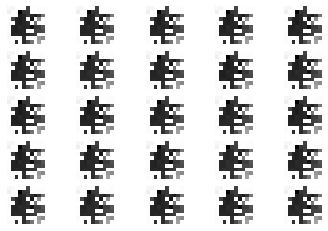

In [0]:
import tensorflow as tf
from tensorflow.keras import layers
noise_dim=100
def make_generator_model(dropout_rate):
    model = tf.keras.Sequential()
    model.add(layers.Dense(5*5*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())

    model.add(layers.Reshape((5, 5, 256)))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

generator=make_generator_model(0.6750692818)
generator.load_weights("gen_12_49.h5")
dim=8791
noise = tf.random.normal([dim, 100])
predictions = generator(noise, training=False)
print(type(predictions))
for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
predictions=tf.reshape(predictions,[dim,10,10])      
print(type(predictions))


In [16]:
import json
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pickle

from tensorflow.keras import Model
from tensorflow.keras.models import load_model


import pandas as pd
import csv
import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Parameters
param = {"Max_A_Size": 10, "Max_B_Size": 10, "Dynamic_Size": False, 'Metod': 'tSNE', "ValidRatio": 0.1, "seed": 180,
          "dir": "/content/Pickle/", "Mode": "CNN2",  # Mode : CNN_Nature, CNN2    | DIR: local working directory
          "res":"/content/drive/My Drive/",#remote path for saving data 
          "LoadFromJson": True, "mutual_info": True, # LoadFromJson: True: load pickle files (images)
          #MOVE Ytrain.pickle and Ytest.pickle to the working directory after generating the images
          "hyper_opt_evals": 20, "epoch": 5, "No_0_MI": False,  # True -> Removing 0 MI Features
          "autoencoder": False,  "cut": None , "use_right_img_model": False,
          "incremental_GAN": False # if true, it load the images from the previous dataset with added attacks
          }

dataset=1 #change dataset
if dataset==1:
  train='TrainOneCls.csv'
  test='Test.csv'
  classif_label='Classification'
  param["attack_label"]=0
elif dataset==2:
  train='Train.csv'
  test='Test_UNSW_NB15.csv'
  classif_label='classification'
  param["attack_label"]=1
elif dataset==3:
  train='Train.csv'
  test='Test.csv'
  classif_label=' classification.'
  param["attack_label"]=1
elif dataset==4:
  train='AAGMTrain_OneClsNumeric.csv'
  test='AAGMTest_OneClsNumeric.csv'
  classif_label='classification'
  param["attack_label"]=0

if not param["LoadFromJson"]:
    data = {}
    with open(param["dir"] + 'AAGMTrain_OneClsNumeric.csv', 'r') as file:
        data = {"Xtrain": pd.DataFrame(list(csv.DictReader(file))).astype(float), "class": 2}
        data["Classification"] = data["Xtrain"]['classification']
        del data["Xtrain"]['classification']
    with open(param["dir"]+'AAGMTest_OneClsNumeric.csv', 'r') as file:
        Xtest = pd.DataFrame(list(csv.DictReader(file)))
        #Xtest.drop(Xtest.keys()[0], axis=1)
        Xtest.replace("", np.nan, inplace=True)
        Xtest.dropna(inplace=True)
        data["Xtest"] = Xtest[Xtest.keys()[1:]].astype(float)
        data["Ytest"] = data["Xtest"]['classification']
        del data["Xtest"]['classification']

        filename = "Ytrain.pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(data["Classification"], f_myfile)
        f_myfile.close()
        filename = "Ytest.pickle"
        f_myfile = open(filename, 'wb')
        pickle.dump(data["Ytest"], f_myfile)
        f_myfile.close()
     # AUTOENCODER
    if param["autoencoder"]:
        autoencoder = load_model(param["dir"] + 'Autoencoder.h5')
        autoencoder.summary()
        encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encod2').output)
        encoder.summary()
        # usa l'encoder con predict sul train_X e poi su test_X. Io qui ho creato anche il dataframe per salvarlo poi come csv
        encoded_train = pd.DataFrame(encoder.predict(data["Xtrain"]))
        data["Xtrain"] = encoded_train.add_prefix('feature_')
        encoded_test = pd.DataFrame(encoder.predict(data["Xtest"]))
        data["Xtest"] = encoded_test.add_prefix('feature_')

    
    model = train_norm(param, data, norm=False)

else:

    images = {}
    if param["mutual_info"]:
     t='MI'
    else:
     t='Mean'

    if param["incremental_GAN"]:
          f_myfile = open(param["dir"] + 'trainGAN.pickle', 'rb')
          images = pickle.load(f_myfile)
          f_myfile.close()

          #correct features
          print(1,type(images["Xtrain"]))
          print(2,type(predictions.numpy().tolist()))
          new=predictions.numpy()
          print(len(new))

          if param["use_right_img_model"] == False: #force to use the train model
            f_myfile = open(param["dir"] + 'model10x10.pickle', 'rb')
            model = pickle.load(f_myfile)
            f_myfile.close()
            plt.imshow(model, cmap='gray')
            plt.show()
            error=0
            do_error=True
            for l in range(new.shape[0]):
              for i in range(new.shape[1]):
                for j in range(new.shape[2]):
                  if model[i,j]==0:
                    if do_error and new[l,i,j]!=0:
                      error=error+1
                    new[l,i,j]=0
                  do_error=False
            print(error)
                  
            #plt.imshow(new[l], cmap='gray')
            #plt.show()      

        
          images["Xtrain"].extend(new)
          print(4,type(images["Classification"].tolist()))
          print(4,type(list(np.zeros(dim))))
          print(5,len(images["Xtrain"]))

          images["Classification"]=images["Classification"].append(pd.Series(np.zeros(dim)))
          filename = param["res"] + "trainGAN.pickle"
          f_myfile = open(filename, 'wb')
          pickle.dump(images, f_myfile)
          f_myfile.close()
    else:
     
          f_myfile = open(param["dir"] + 'train_'+str(param['Max_A_Size'])+'x'+str(param['Max_B_Size'])+'_'+t+'.pickle', 'rb')
          images["Xtrain"] = pickle.load(f_myfile)
          f_myfile.close()

          f_myfile = open(param["dir"] + 'YTrain.pickle', 'rb')
          images["Classification"] = pickle.load(f_myfile)
          f_myfile.close()

          f_myfile = open(param["dir"] + 'test_'+str(param['Max_A_Size'])+'x'+str(param['Max_B_Size'])+'_'+t+'.pickle', 'rb')
          images["Xtest"] = pickle.load(f_myfile)
          f_myfile.close()

          f_myfile = open(param["dir"] + 'YTest.pickle', 'rb')
          images["Ytest"] = pickle.load(f_myfile)
          f_myfile.close()
    model = train_norm(param, images, norm=False)


modelling dataset
shape(900000, 10, 10)
(900000, 10, 10, 1)
(900000,)
start train
{'batch': 32, 'dropout1': 0.7298482887773207, 'dropout2': 0.8039673451520342, 'epoch': 5, 'kernel': 4, 'learning_rate': 0.0009465128129756897}
Epoch 1/5
2500/2500 - 7s - loss: 0.3711 - acc: 0.8638 - val_loss: 0.2659 - val_acc: 0.8863

Epoch 2/5
2500/2500 - 7s - loss: 0.2949 - acc: 0.8862 - val_loss: 0.2119 - val_acc: 0.9175

Epoch 3/5
2500/2500 - 7s - loss: 0.2534 - acc: 0.8995 - val_loss: 0.1731 - val_acc: 0.9225

Epoch 4/5
2500/2500 - 7s - loss: 0.2334 - acc: 0.9039 - val_loss: 0.1627 - val_acc: 0.9235

Epoch 5/5
2500/2500 - 7s - loss: 0.2169 - acc: 0.9090 - val_loss: 0.1488 - val_acc: 0.9317

start predict
(900000, 10, 10, 1)
(900000,)
16000
4000
180000
720000
ok
new saved model:{'balanced_accuracy_val': 89.21875, 'TP_val': 15330, 'FN_val': 670, 'FP_val': 695, 'TN_val': 3305, 'balanced_accuracy_test': 88.94958333333334, 'TN_test': 690282, 'FP_test': 29718, 'FN_test': 32352, 'TP_test': 147648, 'kernel':

KeyboardInterrupt: ignored

In [0]:
imagaes

NameError: ignored

In [0]:
with open('Original dataset/Testing.csv', 'r') as file:
        Xtest = pd.DataFrame(list(csv.DictReader(file)))
        #Xtest.drop(Xtest.keys()[0], axis=1)
        Xtest.replace("", np.nan, inplace=True)
        Xtest.dropna(inplace=True)
        data["Xtest"] = Xtest[Xtest.keys()[1:]].astype(float)
        data["Ytest"] = data["Xtest"]['Classification']
        del data["Xtest"]['Classification']

In [0]:
data["Xtest"].shape

(900000, 78)